notes to improve on

regularisation
transforms
auto lr find
transfer learning?

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib as plt
from pathlib2 import Path
from PIL import Image
import torch
import math
import torch.nn as nn
from torchvision.transforms import transforms
from matplotlib import pyplot
import pandas as pd
from fastai.callbacks import *




The key

Paths

In [3]:
DATA_PATH = Path(os.getcwd()+"/data")
PATH = DATA_PATH/"kaggle"
TRAIN_PATH = PATH/"upsampled_images"
TEST_PATH = PATH/"upsampled_test"

Select Devices

Import CSVs

In [ ]:
sketch_df = pd.read_csv(PATH/'sketches_train.csv')

In [ ]:
sketch_x = sketch_df.iloc[:,1:785]
sketch_x.head

In [ ]:
sketch_y = sketch_df.iloc[:,785:786]
sketch_y.head

In [ ]:
(sketch_x.to_numpy()[5]).shape

In [ ]:
#make images from array
i = 0
for row in sketch_x.to_numpy(): #get numpy array from pandas df 
    arr = row 
    i += 1
    sqr = arr.reshape(28,28).astype(np.uint8)
    img = Image.fromarray(sqr)
    img.save(str(TRAIN_PATH)+"/"+str(i)+".png", "PNG")

In [ ]:
TRAIN_PATH

In [ ]:
#organise images into class folders

shapeIDs = list(sketch_y['word'].unique())

#Run Once to make img
for s in shapeIDs:
    if not os.path.isdir(str(TRAIN_PATH)+'/'+s):
        os.makedirs(str(TRAIN_PATH)+'/'+s)

for idx in sketch_y.index:
    image = str(idx+1)+'.png'
    folder = sketch_y.loc[idx, 'word']
    old = 'C:/Users/georg/.fyp/data/kaggle/upsampled_images/{}'.format(image)
    new = 'C:/Users/georg/.fyp/data/kaggle/upsampled_images/{}/{}'.format(folder, image)
    try:
        os.rename(old, new)
    except:
        print('{} - {}'.format(image,folder))

In [4]:
#try fastai method
from fastai.vision import *
sketch_data = ImageDataBunch.from_folder(TRAIN_PATH, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=114, num_workers=1).normalize(mnist_stats)

In [ ]:
?ImageDataBunch.from_folder

In [ ]:
sketch_data.show_batch(rows=3, figsize=(7,8))

In [5]:
learn = cnn_learner(sketch_data, models.resnet152, metrics=error_rate,
                                       callback_fns=[partial(EarlyStoppingCallback, 
                                          monitor='error_rate', 
                                          mode = 'min',
                                          min_delta=0.0005, 
                                          patience=5),
                                        partial(SaveModelCallback,
                                          every='epoch', 
                                          monitor='error_rate', 
                                          name='model')
                                 ])

In [6]:
learn.fit_one_cycle(30)

epoch,train_loss,valid_loss,error_rate,time
0,1.310377,0.509731,0.176569,00:29
1,0.848749,0.406764,0.127197,00:27
2,0.685361,0.368813,0.122176,00:28
3,0.562983,0.384339,0.115481,00:29
4,0.504300,0.349891,0.107950,00:28
5,0.462581,0.326072,0.101255,00:28
6,0.443031,0.342096,0.106276,00:28
7,0.401586,0.294845,0.093724,00:28
8,0.378445,0.300102,0.098745,00:28
9,0.339933,0.299153,0.094561,00:28


In [7]:
learn.load('model_18')

Learner(data=ImageDataBunch;

Train: LabelList (4782 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
banana,banana,banana,banana,banana
Path: C:\Users\georg\fyp\data\kaggle\upsampled_images;

Valid: LabelList (1195 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
flip flops,kangaroo,crab,banana,kangaroo
Path: C:\Users\georg\fyp\data\kaggle\upsampled_images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

In [8]:
learn.freeze()

In [9]:
learn.unfreeze()

In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


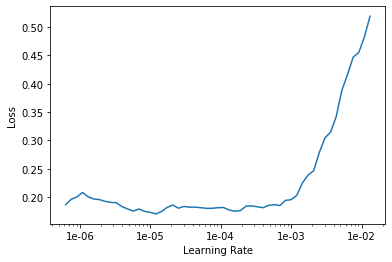

In [11]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(30, max_lr=slice(1e-5,1e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.190635,0.221137,0.068619,00:28
1,0.175722,0.219101,0.068619,00:31
2,0.166046,0.217399,0.066946,00:31
3,0.169259,0.221050,0.069456,00:29
4,0.166310,0.217359,0.067782,00:31
5,0.164995,0.216554,0.064435,00:33
6,0.168027,0.214047,0.066109,00:29
7,0.162835,0.210935,0.065272,00:30
8,0.155740,0.209605,0.065272,00:30
9,0.155682,0.207793,0.060251,00:31


Epoch 24: early stopping


In [13]:
learn.load('model_20')

Learner(data=ImageDataBunch;

Train: LabelList (4782 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
banana,banana,banana,banana,banana
Path: C:\Users\georg\fyp\data\kaggle\upsampled_images;

Valid: LabelList (1195 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
flip flops,kangaroo,crab,banana,kangaroo
Path: C:\Users\georg\fyp\data\kaggle\upsampled_images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
learn.export()

In [ ]:
test_df = pd.read_csv(PATH/'sketches_test.csv')

In [ ]:
test_df.head

In [14]:
defaults.device = torch.device('cpu')
from PIL import Image

pred_class = []
pred_idx = []
outputs = []

for i in range(1200):
    idx = i+1
    img = open_image(str(TEST_PATH)+"/"+str(idx)+".png")
    a,b,c = learn.predict(img)
    pred_class.append(a)
    pred_idx.append(b)
    outputs.append(c)




In [15]:
df = pd.DataFrame(data={"id": range(1,1201,1), "Category": pred_class})
df.to_csv("./result_pd.csv", sep=',',index=False)

In [ ]:
from fastai.widgets import *

In [ ]:
db = (ImageList.from_folder(TRAIN_PATH)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=114)
                   .databunch()
     )

In [ ]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [ ]:
something, ds, idxs = DatasetFormatter().from_most_unsure(db, learn_cln)

In [ ]:
?ImageCleaner

In [ ]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, TRAIN_PATH)